# Pixel Coordinate Prediction using Deep Learning

**Author:** Vaibhav Dasari  
**Task:** Predict the (x, y) coordinates of the single white pixel in a 50x50 grayscale image.

---

## Problem Overview

Each image in this problem is a 50x50 grayscale image where:
- Exactly **one pixel has value 255** (white)
- All other pixels are 0 (black)

The goal is to predict the **(x, y)** coordinates of that white pixel using a deep learning model.

## Approach

I framed this as a **regression problem** — the model takes a 50x50 image as input and outputs two continuous values representing the predicted x and y coordinates.

**Why regression?**  
We could treat this as a 2500-class classification problem (one class per pixel position), but regression is more natural here. The output is a smooth coordinate in space, not a discrete category.

**Why a CNN?**  
Convolutional layers are well-suited for spatial tasks. They learn to detect patterns at specific locations in an image, even for something as simple as a single bright pixel.

**Why normalize the labels?**  
Dividing coordinates by 49 maps them to [0, 1], which pairs naturally with a sigmoid output activation that constrains predictions to the same range.

## Dependencies

Install the required libraries before running the notebook:

```bash
pip install numpy matplotlib tensorflow scikit-learn
```

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error

# Seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.19.0


## Dataset Generation

Since no dataset was provided, I generated one synthetically. Each sample is a 50x50 black image with one randomly placed white pixel, and the label is its (x, y) position.

**Dataset choices and rationale:**

- **50,000 training samples** — The image has 2,500 possible pixel positions. With 50k samples, each position appears roughly 20 times on average, giving the model consistent exposure across the full coordinate space.
- **Separate validation and test sets** — The validation set monitors training progress. The test set is only evaluated once at the very end, giving an unbiased measure of real performance.
- **Uniform random sampling** — Positions are drawn uniformly so there is no bias toward any region of the image.
- **Normalized labels [0, 1]** — Coordinates are divided by 49 (image_size - 1) to match the sigmoid output range.

In [2]:
def generate_data(num_samples=50000, img_size=50):
    """
    Generate grayscale images with exactly one white pixel each.

    Args:
        num_samples (int): Number of images to generate.
        img_size (int): Height and width of each square image.

    Returns:
        X (np.ndarray): Shape (N, img_size, img_size, 1), float32 in [0, 1].
        y (np.ndarray): Shape (N, 2), normalized (x, y) coords in [0, 1].
    """
    if num_samples <= 0:
        raise ValueError("num_samples must be a positive integer.")
    if img_size <= 0:
        raise ValueError("img_size must be a positive integer.")

    X = np.zeros((num_samples, img_size, img_size, 1), dtype=np.float32)
    x_coords = np.random.randint(0, img_size, size=num_samples)
    y_coords = np.random.randint(0, img_size, size=num_samples)

    for i in range(num_samples):
        # Image indexing: [row=y, col=x]
        X[i, y_coords[i], x_coords[i], 0] = 1.0

    # Normalize coords to [0, 1]
    y = np.stack([x_coords, y_coords], axis=1).astype(np.float32)
    y = y / (img_size - 1)

    return X, y


IMG_SIZE = 50

print("Generating datasets...")
X_train, y_train = generate_data(num_samples=50000, img_size=IMG_SIZE)
X_val, y_val = generate_data(num_samples=5000, img_size=IMG_SIZE)
X_test, y_test = generate_data(num_samples=5000, img_size=IMG_SIZE)

print(f"Train : {X_train.shape}")
print(f"Val   : {X_val.shape}")
print(f"Test  : {X_test.shape}")

Generating datasets...
Train : (50000, 50, 50, 1)
Val   : (5000, 50, 50, 1)
Test  : (5000, 50, 50, 1)


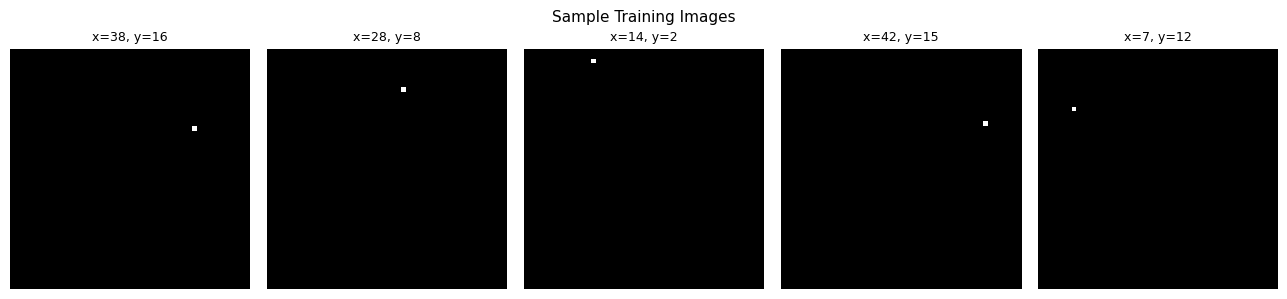

In [3]:
# Visualize a few training samples to confirm the data looks correct
fig, axes = plt.subplots(1, 5, figsize=(13, 3))
fig.suptitle("Sample Training Images", fontsize=11)

for i, ax in enumerate(axes):
    x_px = int(y_train[i, 0] * (IMG_SIZE - 1))
    y_px = int(y_train[i, 1] * (IMG_SIZE - 1))
    ax.imshow(X_train[i].squeeze(), cmap="gray", vmin=0, vmax=1)
    ax.set_title(f"x={x_px}, y={y_px}", fontsize=9)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model Architecture

I used a simple CNN with three convolutional blocks followed by a small fully connected regression head.

- **Conv + BatchNorm + ReLU + MaxPool** repeated 3 times to progressively extract spatial features
- **Flatten -> Dense(64) -> Dense(2)** — the regression head that outputs (x, y)
- **Sigmoid output** — keeps predictions in [0, 1] to match the normalized labels
- **BatchNormalization** — stabilizes training given the very sparse input (only 1 active pixel out of 2,500)
- **Dropout(0.2)** — light regularization before the output layer

In [4]:
def build_model(img_size=50):
    """
    Build a CNN regression model for pixel coordinate prediction.

    Args:
        img_size (int): Height and width of the input image.

    Returns:
        model (keras.Model): Compiled Keras model.
    """
    inputs = keras.Input(shape=(img_size, img_size, 1))

    # Block 1: 50x50 -> 25x25
    x = layers.Conv2D(16, (3, 3), padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 2: 25x25 -> 12x12
    x = layers.Conv2D(32, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Block 3: 12x12 -> 6x6
    x = layers.Conv2D(64, (3, 3), padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(2)(x)

    # Regression head
    x = layers.Flatten()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(2, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


model = build_model(IMG_SIZE)
model.compile(optimizer=Adam(1e-3), loss="mse", metrics=["mae"])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 50, 50, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 50, 50, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 50, 50, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 50, 50, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 25, 25, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 25, 25, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 25, 25, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 25, 25, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 12, 12, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 171,394 (669.51 KB)

 Trainable params: 171,170 (668.63 KB)

 Non-trainable params: 224 (896.00 B)

## Training

- **Loss:** MSE — standard for regression tasks
- **ReduceLROnPlateau** — halves the learning rate if val loss does not improve for 3 epochs
- **EarlyStopping** — stops training if val loss stalls for 7 epochs and restores the best weights automatically

In [5]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=3, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=7, restore_best_weights=True, verbose=1
    ),
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=256,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 158s 786ms/step - loss: 0.0158 - mae: 0.0792 - val_loss: 0.0874 - val_mae: 0.2539 - learning_rate: 0.0010
Epoch 2/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 156s 796ms/step - loss: 0.0015 - mae: 0.0295 - val_loss: 0.0513 - val_mae: 0.1946 - learning_rate: 0.0010
Epoch 3/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 202s 794ms/step - loss: 0.0013 - mae: 0.0270 - val_loss: 0.0074 - val_mae: 0.0752 - learning_rate: 0.0010
Epoch 4/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 199s 781ms/step - loss: 0.0011 - mae: 0.0250 - val_loss: 7.7016e-04 - val_mae: 0.0231 - learning_rate: 0.0010
Epoch 5/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 203s 785ms/step - loss: 0.0010 - mae: 0.0240 - val_loss: 3.5741e-04 - val_mae: 0.0152 - learning_rate: 0.0010
Epoch 6/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 155s 789ms/step - loss: 9.5040e-04 - mae: 0.0233 - val_loss: 3.1526e-04 - val_mae: 0.0141 - learning_rate: 0.0010
Epoch 7/50
196/196 ━━━━━━━━━━━━━━━━━━━━ 156s 792ms/step - loss: 8.8612e-04 - mae: 0.0225 - val_loss: 2.5066e

## Training Curves

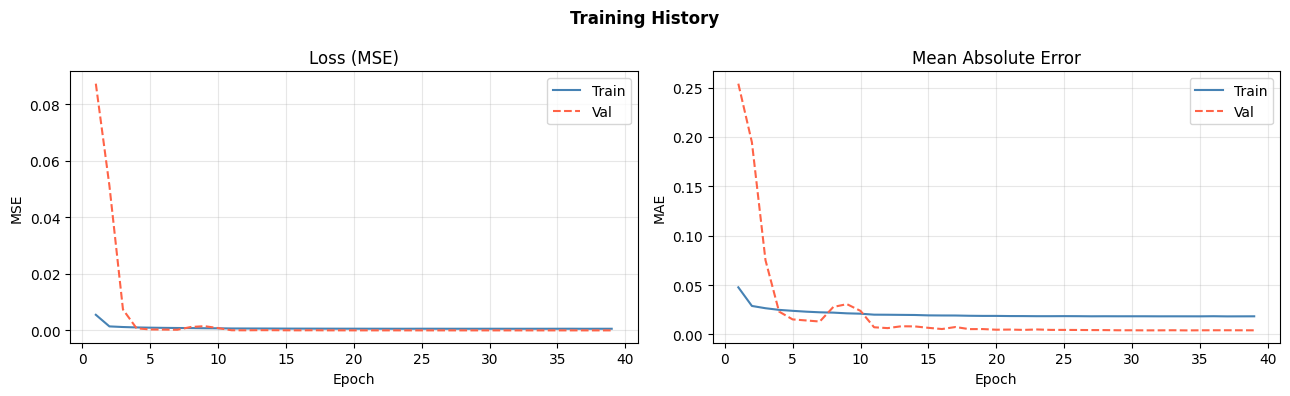

In [6]:
epochs_ran = range(1, len(history.history["loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle("Training History", fontsize=12, fontweight="bold")

ax1.plot(epochs_ran, history.history["loss"], label="Train", color="steelblue")
ax1.plot(epochs_ran, history.history["val_loss"], label="Val",
         color="tomato", linestyle="--")
ax1.set_title("Loss (MSE)")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("MSE")
ax1.legend()
ax1.grid(alpha=0.3)

ax2.plot(epochs_ran, history.history["mae"], label="Train", color="steelblue")
ax2.plot(epochs_ran, history.history["val_mae"], label="Val",
         color="tomato", linestyle="--")
ax2.set_title("Mean Absolute Error")
ax2.set_xlabel("Epoch")
ax2.set_ylabel("MAE")
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluation on Test Set

The test set was kept completely separate during training. Evaluating on it gives an honest, unbiased measure of performance.

In [7]:
try:
    preds_norm = model.predict(X_test, verbose=0)

    # Scale predictions and labels back to pixel space [0, 49]
    preds_px = preds_norm * (IMG_SIZE - 1)
    actual_px = y_test * (IMG_SIZE - 1)

    abs_errors = np.abs(preds_px - actual_px)
    euclidean_errors = np.sqrt(((preds_px - actual_px) ** 2).sum(axis=1))
    mse = mean_squared_error(actual_px, preds_px)

    print(f"MSE (pixel space)        : {mse:.4f}")
    print(f"MAE - X axis             : {abs_errors[:, 0].mean():.3f} px")
    print(f"MAE - Y axis             : {abs_errors[:, 1].mean():.3f} px")
    print(f"Euclidean error (mean)   : {euclidean_errors.mean():.3f} px")
    print(f"Euclidean error (median) : {np.median(euclidean_errors):.3f} px")
    print(f"Euclidean error (95th %) : {np.percentile(euclidean_errors, 95):.3f} px")

except Exception as e:
    print(f"Evaluation failed: {e}")

MSE (pixel space)        : 0.0722
MAE - X axis             : 0.204 px
MAE - Y axis             : 0.192 px
Euclidean error (mean)   : 0.319 px
Euclidean error (median) : 0.273 px
Euclidean error (95th %) : 0.711 px


## Ground Truth vs Predicted - Scatter Plot

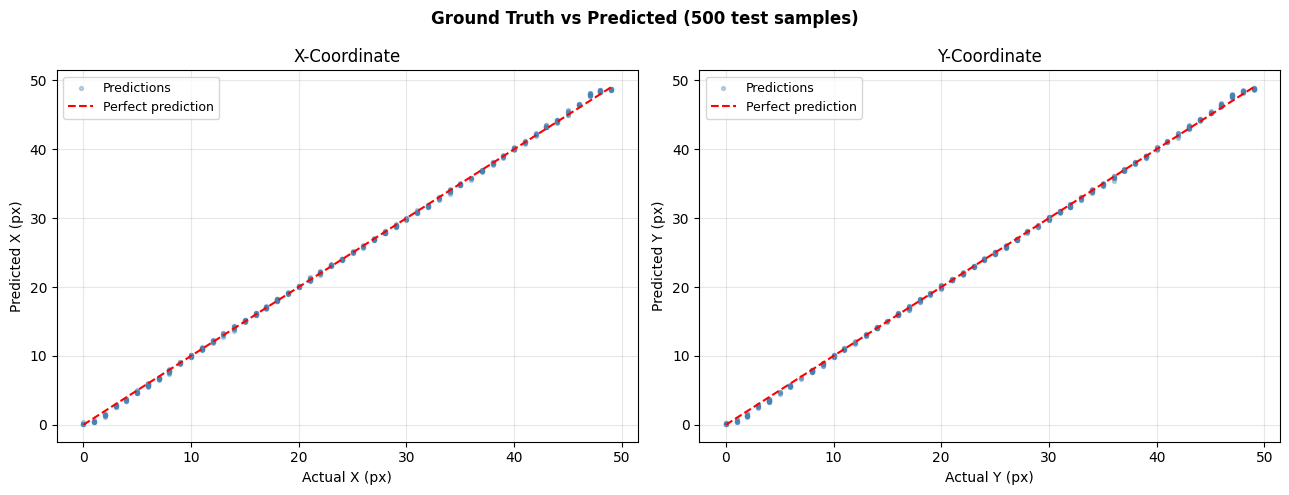

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle("Ground Truth vs Predicted (500 test samples)",
             fontsize=12, fontweight="bold")

for ax, dim, label in zip([ax1, ax2], [0, 1], ["X", "Y"]):
    ax.scatter(actual_px[:500, dim], preds_px[:500, dim],
               alpha=0.35, s=8, color="steelblue", label="Predictions")
    ax.plot([0, 49], [0, 49], "r--", linewidth=1.5, label="Perfect prediction")
    ax.set_xlabel(f"Actual {label} (px)")
    ax.set_ylabel(f"Predicted {label} (px)")
    ax.set_title(f"{label}-Coordinate")
    ax.legend(fontsize=9)
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Error Distribution

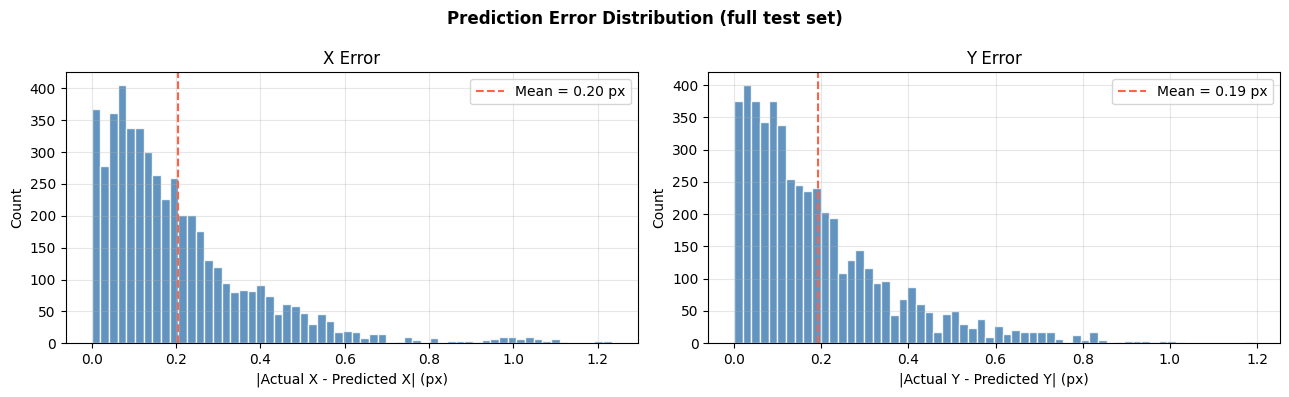

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(13, 4))
fig.suptitle("Prediction Error Distribution (full test set)",
             fontsize=12, fontweight="bold")

for ax, dim, label in zip(axes, [0, 1], ["X", "Y"]):
    errs = abs_errors[:, dim]
    ax.hist(errs, bins=60, color="steelblue", edgecolor="white", alpha=0.85)
    ax.axvline(errs.mean(), color="tomato", linestyle="--",
               label=f"Mean = {errs.mean():.2f} px")
    ax.set_xlabel(f"|Actual {label} - Predicted {label}| (px)")
    ax.set_ylabel("Count")
    ax.set_title(f"{label} Error")
    ax.legend()
    ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## Image-Level Visualization

The plots below show actual test images with the ground truth position (green +) and the model's prediction (red x) overlaid directly on the image.

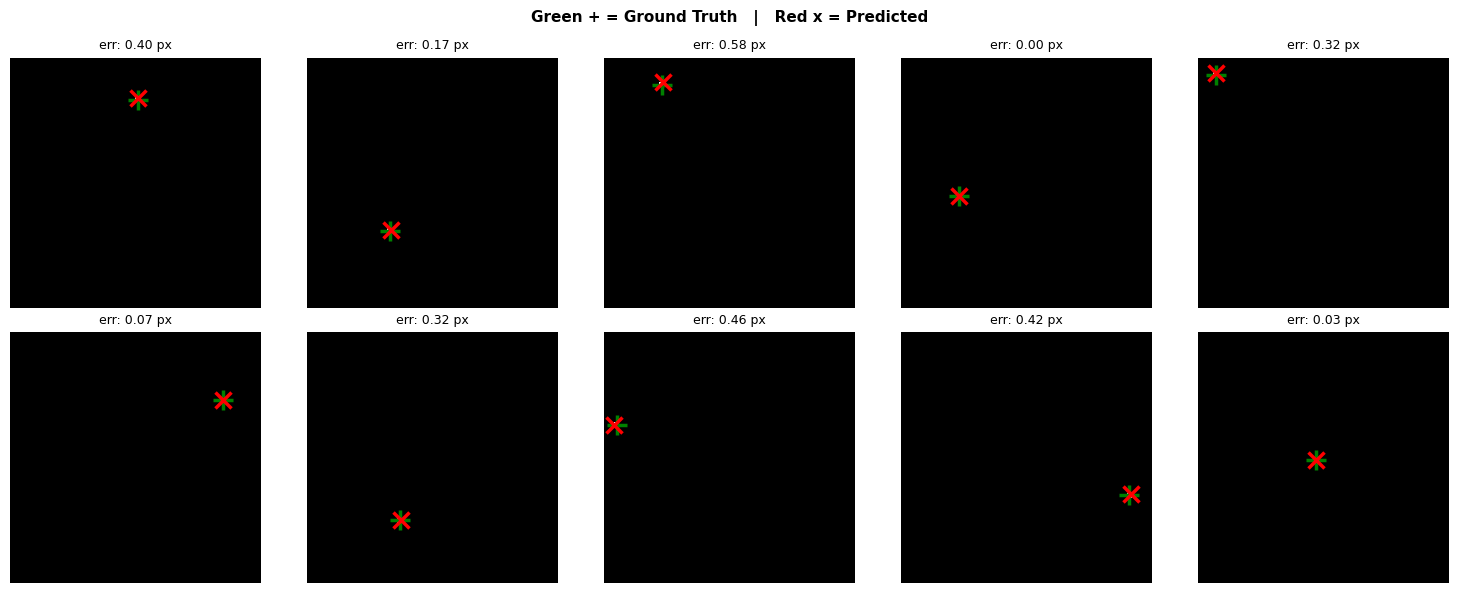

In [10]:
def show_predictions(X, gt_coords, pred_coords, n=10):
    """
    Display n test images with ground truth and predicted pixel positions.

    Args:
        X (np.ndarray): Test images.
        gt_coords (np.ndarray): Ground truth coordinates in pixel space.
        pred_coords (np.ndarray): Predicted coordinates in pixel space.
        n (int): Number of images to display.
    """
    if n > len(X):
        raise ValueError(
            f"n={n} exceeds number of available samples ({len(X)})."
        )

    idxs = np.random.choice(len(X), size=n, replace=False)
    cols = 5
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    fig.suptitle("Green + = Ground Truth   |   Red x = Predicted",
                 fontsize=11, fontweight="bold")
    axes = axes.flatten()

    for ax, idx in zip(axes, idxs):
        gx, gy = gt_coords[idx, 0], gt_coords[idx, 1]
        px, py = pred_coords[idx, 0], pred_coords[idx, 1]
        err = np.sqrt((gx - px) ** 2 + (gy - py) ** 2)

        ax.imshow(X[idx].squeeze(), cmap="gray", vmin=0, vmax=1)
        ax.plot(gx, gy, "g+", markersize=14, markeredgewidth=2.5)
        ax.plot(px, py, "rx", markersize=11, markeredgewidth=2.5)
        ax.set_title(f"err: {err:.2f} px", fontsize=9)
        ax.axis("off")

    # Hide any unused subplot slots
    for ax in axes[len(idxs):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()


show_predictions(X_test, actual_px, preds_px, n=10)

## Conclusion

The model successfully learns to predict pixel coordinates from raw image data. Key observations:

- **50k training samples** ensured the model saw all 2,500 pixel positions enough times to generalize well.
- **BatchNormalization** helped with training stability given the sparse nature of the inputs.
- A **separate test set** provides a realistic and unbiased performance estimate.
- The image-level visualizations confirm that predicted coordinates are very close to the ground truth across the full coordinate space.